## Experiment to Visualize LFP Decision Boundaries on Toy Data

### Imports

In [1]:
import os
import joblib
import random
import copy
from tqdm import tqdm

# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import matplotlib.pyplot as plt
import numpy as np
import torch
import os

from experiment_utils.model import models as models
from experiment_utils.data import transforms as transforms
from experiment_utils.data import datasets as datasets
from experiment_utils.data import dataloaders as dataloaders
from lfprop.propagation import propagator_lxt as propagator
from experiment_utils.evaluation import evaluate as evaluate
from lfprop.rewards import rewards as rewards
from experiment_utils.utils.utils import register_backward_normhooks

### Experiment Variables

In [2]:
dataset_name = "blobs"  # Options: swirls, circles, blobs
n_channels = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
lrs = np.sort(
    np.array(
        [
            np.arange(1, 11, 1, dtype=float) * 10**x
            for x in [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3]
        ]
    ).flatten()
)
momentum = 0.95
reward_name = "softmaxlossreward"
loss_name = "ce-loss"
norm_backward = False
epochs = 10  # 15 epochs for swirls, 10 otherwise
n_datasets = 5
activations = ["leakyrelu", "step", "silu", "elu", "tanh"]

savepath = "<path to save results in>"
data_path = "<path where dataset is saved>"

retrain_models = False
redraw_data = False

In [3]:
class ToyDataDense(torch.nn.Module):
    """
    Dense Model for Toy Data
    """

    def __init__(
        self, n_channels, n_outputs, activation=torch.nn.ReLU, activation_kwargs=None
    ):
        super().__init__()

        if activation_kwargs is None:
            activation_kwargs = {}

        # Classifier
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(n_channels, 32),
            activation(**activation_kwargs),
            torch.nn.Linear(32, 16),
            activation(**activation_kwargs),
            torch.nn.Linear(16, n_outputs),
            activation(**activation_kwargs),
        )

    def forward(self, x):
        """
        Forwards input through network
        """

        # Forward through network
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        # Return output
        return x

### Trainer Class

In [4]:
class Trainer:
    def __init__(
        self,
        model,
        train_dataset,
        test_dataset,
        val_dataset,
        optimizer,
        criterion,
        device,
        lfp_composite=None,
        norm_backward=False,
    ):
        self.model = model
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.val_dataset = val_dataset
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = None
        self.device = device
        self.lfp_composite = lfp_composite
        self.norm_backward = norm_backward
        self.global_epoch = 0
        self.global_step = 0

        self.train_loader = dataloaders.get_dataloader(
            dataset_name=dataset_name,
            dataset=train_dataset,
            batch_size=batch_size,
            shuffle=True,
        )
        self.test_loader = dataloaders.get_dataloader(
            dataset_name=dataset_name,
            dataset=test_dataset,
            batch_size=batch_size,
            shuffle=False,
        )
        self.val_loader = dataloaders.get_dataloader(
            dataset_name=dataset_name,
            dataset=val_dataset,
            batch_size=batch_size,
            shuffle=False,
        )

        self.accuracy_log = {"train": [], "test": []}

    def grad_step(self, inputs, labels):
        # Backward norm
        if self.norm_backward:
            norm_handles = register_backward_normhooks(self.model)
        else:
            norm_handles = []

        self.model.train()
        with torch.enable_grad():
            self.optimizer.zero_grad()
            out = self.model(inputs)

            reward = self.criterion(out, labels)
            reward.backward()

            self.optimizer.step()

        self.model.eval()

        for handle in norm_handles:
            handle.remove()

        self.global_step += 1

    def lfp_step(self, inputs, labels):
        self.model.train()

        with torch.enable_grad():
            self.optimizer.zero_grad()
            with self.lfp_composite.context(self.model) as modified:
                inputs = inputs.detach().requires_grad_(True)
                outputs = modified(inputs)

                # Calculate reward
                # Do like this to avoid tensors being kept in memory
                reward = torch.from_numpy(
                    self.criterion(outputs, labels).detach().cpu().numpy()
                ).to(device)

                # Write LFP Values into .grad attributes
                input_reward = torch.autograd.grad(
                    (outputs,), (inputs,), grad_outputs=(reward,), retain_graph=False
                )[0]

                for name, param in self.model.named_parameters():
                    param.grad = -param.feedback

                self.optimizer.step()

        self.model.eval()

        self.global_step += 1

    def train(
        self,
        epochs,
        verbose=False,
        savepath=None,
        savename="ckpt",
        saveappendage="last",
        fromscratch=False,
    ):

        if not fromscratch and savepath:
            self.load(savepath, savename, saveappendage)

        if verbose:

            eval_stats = self.eval(datamodes=["train", "test"])

            print(eval_stats)

            print(
                "Initial Eval: (Train Criterion) {:.2f}; (Train Accuracy) {:.2f}; (Test Criterion) {:.2f}; (Test Accuracy) {:.2f}".format(
                    float(np.mean(eval_stats["train"]["criterion"])),
                    (
                        float(eval_stats["train"]["accuracy_p050"])
                        if "accuracy_p050" in eval_stats["train"].keys()
                        else float(eval_stats["train"]["micro_accuracy_top1"])
                    ),
                    float(np.mean(eval_stats["test"]["criterion"])),
                    (
                        float(eval_stats["test"]["accuracy_p050"])
                        if "accuracy_p050" in eval_stats["test"].keys()
                        else float(eval_stats["test"]["micro_accuracy_top1"])
                    ),
                )
            )

        for epoch in range(epochs):
            with tqdm(total=len(self.train_loader), disable=not verbose) as pbar:
                for index, (inputs, labels) in enumerate(self.train_loader):
                    inputs = inputs.to(device)
                    labels = torch.tensor(labels).to(device)

                    if self.lfp_composite is None:
                        # Grad Step
                        self.grad_step(inputs, labels)
                    else:
                        # LFP Step
                        self.lfp_step(inputs, labels)

                    pbar.update(1)

                    if self.global_step % 5 == 0:
                        eval_stats = self.eval(datamodes=["train", "test"])
                        self.accuracy_log["train"].append(
                            (
                                float(eval_stats["train"]["accuracy_p050"])
                                if "accuracy_p050" in eval_stats["train"].keys()
                                else float(eval_stats["train"]["micro_accuracy_top1"])
                            ),
                        )
                        self.accuracy_log["test"].append(
                            (
                                float(eval_stats["test"]["accuracy_p050"])
                                if "accuracy_p050" in eval_stats["test"].keys()
                                else float(eval_stats["test"]["micro_accuracy_top1"])
                            ),
                        )

            if verbose:

                eval_stats = self.eval(datamodes=["train", "test"])

                print(
                    "Epoch {}/{}: (Train Criterion) {:.2f}; (Train Accuracy) {:.2f}; (Test Criterion) {:.2f}; (Test Accuracy) {:.2f}".format(
                        epoch + 1,
                        epochs,
                        float(np.mean(eval_stats["train"]["criterion"])),
                        (
                            float(eval_stats["train"]["accuracy_p050"])
                            if "accuracy_p050" in eval_stats["train"].keys()
                            else float(eval_stats["train"]["micro_accuracy_top1"])
                        ),
                        float(np.mean(eval_stats["test"]["criterion"])),
                        (
                            float(eval_stats["test"]["accuracy_p050"])
                            if "accuracy_p050" in eval_stats["test"].keys()
                            else float(eval_stats["test"]["micro_accuracy_top1"])
                        ),
                    )
                )

            self.global_epoch += 1

            if savepath:
                self.save(savepath, savename, "last")

    def eval(self, datamodes=["train", "test", "val"]):

        return_dict = {}

        if "train" in datamodes:
            return_data = evaluate.eval(
                self.model, self.train_loader, self.criterion, device
            )
            return_dict["train"] = return_data
        if "test" in datamodes:
            return_data = evaluate.eval(
                self.model, self.test_loader, self.criterion, device
            )
            return_dict["test"] = return_data
        if "val" in datamodes:
            return_data = evaluate.eval(
                self.model, self.val_loader, self.criterion, device
            )
            return_dict["val"] = return_data

        return return_dict

    def save(self, savepath, savename, saveappendage):
        checkpoint = {
            "epoch": self.global_epoch,
            "step": self.global_step,
            "random_state": {
                "torch": torch.get_rng_state(),
                "cuda": torch.cuda.get_rng_state(self.device),
                "numpy": np.random.get_state(),
                "random": random.getstate(),
            },
        }
        if self.model:
            checkpoint["model"] = self.model.state_dict()
        if self.optimizer:
            checkpoint["optimizer"] = self.optimizer.state_dict()
        if self.scheduler:
            checkpoint["scheduler"] = self.scheduler.state_dict()
        if self.accuracy_log:
            checkpoint["accuracy_log"] = self.accuracy_log

        torch.save(checkpoint, os.path.join(savepath, f"{savename}-{saveappendage}.pt"))

    def load(self, savepath, savename, saveappendage):
        if os.path.exists(os.path.join(savepath, f"{savename}-{saveappendage}.pt")):
            checkpoint = torch.load(
                os.path.join(savepath, f"{savename}-{saveappendage}.pt")
            )
            if self.model:
                self.model.load_state_dict(checkpoint["model"])
            if self.optimizer:
                self.optimizer.load_state_dict(checkpoint["optimizer"])
            if self.scheduler:
                self.scheduler.load_state_dict(checkpoint["scheduler"])
            if "accuracy_log" in checkpoint:
                self.accuracy_log = checkpoint["accuracy_log"]
            self.global_epoch = checkpoint["epoch"]
            self.global_step = checkpoint["step"]

            torch.set_rng_state(checkpoint["random_state"]["torch"])
            torch.cuda.set_rng_state(checkpoint["random_state"]["cuda"], device)
            np.random.set_state(checkpoint["random_state"]["numpy"])
            random.setstate(checkpoint["random_state"]["random"])

        else:
            print("No checkpoint found... not loading anything.")

### Paths, Dataset, Model

In [5]:
os.makedirs(data_path, exist_ok=True)
train_datasets = []
for d in range(n_datasets):
    train_datasets.append(
        datasets.get_dataset(
            dataset_name,
            os.path.join(data_path, f"{dataset_name}-train-{d}.json"),
            transforms.get_transforms(dataset_name, "train"),
            mode="train",
            redraw=redraw_data,
        )
    )
test_dataset = datasets.get_dataset(
    dataset_name,
    os.path.join(data_path, f"{dataset_name}-test.json"),
    transforms.get_transforms(dataset_name, "test"),
    mode="test",
    redraw=redraw_data,
)
val_dataset = datasets.get_dataset(
    dataset_name,
    os.path.join(data_path, f"{dataset_name}-val.json"),
    transforms.get_transforms(dataset_name, "test"),
    mode="test",
    redraw=redraw_data,
)

propagation_composites = {
    "lfp-epsilon": propagator.LFPEpsilonComposite(
        norm_backward=norm_backward,
    ),
    "vanilla-gradient": None,
}

init_models = {}
for activation in activations:

    if retrain_models or not os.path.exists(
        os.path.join(savepath, "init-ckpts", f"initmodel-0.pt")
    ):
        init_models[activation] = [
            ToyDataDense(
                n_channels, d.num_classes, activation=models.ACTIVATION_MAP[activation]
            ).to(device)
            for d in train_datasets
        ]
        os.makedirs(os.path.join(savepath, "init-ckpts"), exist_ok=True)
        for m, model in enumerate(init_models[activation]):
            torch.save(
                model.state_dict(),
                os.path.join(savepath, "init-ckpts", f"initmodel-{m}.pt"),
            )
    else:
        init_models[activation] = [
            ToyDataDense(
                n_channels, d.num_classes, activation=models.ACTIVATION_MAP[activation]
            ).to(device)
            for d in train_datasets
        ]
        for m, model in enumerate(init_models[activation]):
            statedict = torch.load(
                os.path.join(savepath, "init-ckpts", f"initmodel-{m}.pt")
            )
            model.load_state_dict(statedict)

trainers = {}
for activation in activations:
    trainers[activation] = {}
    for lr in lrs:
        trainers[activation][lr] = {}
        for name, prop_comp in propagation_composites.items():
            trainers[activation][lr][name] = []
            for d, data in enumerate(train_datasets):
                model = copy.deepcopy(init_models[activation][d])
                trainers[activation][lr][name].append(
                    Trainer(
                        model=model,
                        train_dataset=data,
                        test_dataset=test_dataset,
                        val_dataset=val_dataset,
                        optimizer=torch.optim.SGD(
                            model.parameters(), lr=lr, momentum=momentum
                        ),
                        criterion=(
                            rewards.get_reward(reward_name, device)
                            if prop_comp is not None
                            else rewards.get_reward(loss_name, device)
                        ),
                        device=device,
                        lfp_composite=prop_comp,
                        norm_backward=norm_backward,
                    )
                )

Loaded existing dataset at /media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/reward-backprop/resubmission-1-experiments/decision-boundaries-blobs-activations/blobs-datasets/blobs-train-0.json
Loaded existing dataset at /media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/reward-backprop/resubmission-1-experiments/decision-boundaries-blobs-activations/blobs-datasets/blobs-train-1.json
Loaded existing dataset at /media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/reward-backprop/resubmission-1-experiments/decision-boundaries-blobs-activations/blobs-datasets/blobs-train-2.json
Loaded existing dataset at /media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/reward-backprop/resubmission-1-experiments/decision-boundaries-blobs-activations/blobs-datasets/blobs-train-3.json
Loaded existing dataset at /media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/reward-backprop/resubmission-1-experiments/decision-boundaries-blobs-activations/blobs-datasets/blobs-train-4.json
Loaded existing dataset at /me

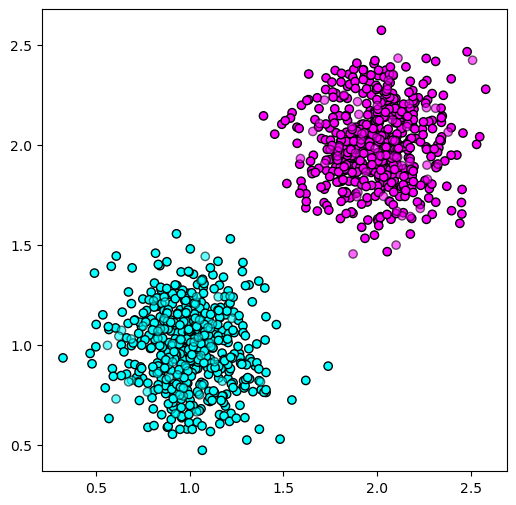

In [6]:
# Plot Data
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

X = np.array([s[0] for s in train_datasets[0].samples])
y = [s[1] for s in train_datasets[0].samples]
ax.scatter(X[:, 0], X[:, 1], c=y, cmap="cool", edgecolors="k")


X = np.array([s[0] for s in test_dataset.samples])
y = [s[1] for s in test_dataset.samples]
ax.scatter(X[:, 0], X[:, 1], c=y, cmap="cool", edgecolors="k", alpha=0.6)

plt.show()

In [7]:
accuracies = {"val": {}, "test": {}, "train": {}}
for activation, trainers_act in trainers.items():
    print(f"Activation {activation}...")
    accuracies["val"][activation] = {}
    accuracies["test"][activation] = {}
    accuracies["train"][activation] = {}
    for lr, trainers_lr in trainers_act.items():
        print(f"LR {lr}...")
        accuracies["val"][activation][lr] = {}
        accuracies["test"][activation][lr] = {}
        accuracies["train"][activation][lr] = {}
        for name, trainer_list in trainers_lr.items():
            accuracies["val"][activation][lr][name] = []
            accuracies["test"][activation][lr][name] = []
            accuracies["train"][activation][lr][name] = []

            for t, trainer in enumerate(trainer_list):
                ckpt_path = os.path.join(savepath, f"ckpts-act-{activation}-lr-{lr}")
                os.makedirs(ckpt_path, exist_ok=True)
                savename = f"{name}-model-{t}"
                saveappendage = "last"
                if retrain_models or not os.path.exists(
                    os.path.join(ckpt_path, f"{savename}-{saveappendage}.pt")
                ):
                    # print(f"Training {t+1}-th trainer for propagator {name}...")
                    trainer.train(
                        epochs=epochs,
                        verbose=False,
                        savepath=ckpt_path,
                        savename=savename,
                        saveappendage=saveappendage,
                        fromscratch=True,
                    )
                else:
                    # print(f"Loading checkpoint {os.path.join(ckpt_path, f'{savename}-{saveappendage}.pt')}")
                    trainer.load(
                        savepath=ckpt_path,
                        savename=savename,
                        saveappendage=saveappendage,
                    )
                eval_stats = trainer.eval(datamodes=["test", "val", "train"])
                # print(f'(Test Accuracy) {res["test"]["accuracy"]}')
                accuracies["val"][activation][lr][name].append(
                    eval_stats["val"]["accuracy_p050"]
                    if "accuracy_p050" in eval_stats["val"].keys()
                    else eval_stats["val"]["micro_accuracy_top1"]
                )
                accuracies["test"][activation][lr][name].append(
                    eval_stats["test"]["accuracy_p050"]
                    if "accuracy_p050" in eval_stats["test"].keys()
                    else eval_stats["test"]["micro_accuracy_top1"]
                )
                accuracies["train"][activation][lr][name].append(
                    eval_stats["train"]["accuracy_p050"]
                    if "accuracy_p050" in eval_stats["train"].keys()
                    else eval_stats["train"]["micro_accuracy_top1"]
                )

Activation leakyrelu...
LR 1e-08...
LR 2e-08...
LR 3.0000000000000004e-08...
LR 4e-08...
LR 5e-08...
LR 6.000000000000001e-08...
LR 7e-08...
LR 8e-08...
LR 9e-08...
LR 1e-07...
LR 2e-07...
LR 3e-07...
LR 4e-07...
LR 5e-07...
LR 6e-07...
LR 7e-07...
LR 8e-07...
LR 9e-07...
LR 1e-06...
LR 2e-06...
LR 3e-06...
LR 4e-06...
LR 4.9999999999999996e-06...
LR 6e-06...
LR 7e-06...
LR 8e-06...
LR 9e-06...
LR 9.999999999999999e-06...
LR 1e-05...
LR 2e-05...
LR 3.0000000000000004e-05...
LR 4e-05...
LR 5e-05...
LR 6.000000000000001e-05...
LR 7.000000000000001e-05...
LR 8e-05...
LR 9e-05...
LR 0.0001...
LR 0.0002...
LR 0.00030000000000000003...
LR 0.0004...
LR 0.0005...
LR 0.0006000000000000001...
LR 0.0007...
LR 0.0008...
LR 0.0009000000000000001...
LR 0.001...
LR 0.002...
LR 0.003...
LR 0.004...
LR 0.005...
LR 0.006...
LR 0.007...
LR 0.008...
LR 0.009000000000000001...
LR 0.01...
LR 0.02...
LR 0.03...
LR 0.04...
LR 0.05...
LR 0.06...
LR 0.07...
LR 0.08...
LR 0.09...
LR 0.1...
LR 0.2...
LR 0.3000000

In [8]:
# Plot Settings
# Set font properties.
import matplotlib.font_manager as font_manager

font_path = plt.matplotlib.get_data_path() + "/fonts/ttf/cmr10.ttf"
cmfont = font_manager.FontProperties(fname=font_path)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = cmfont.get_name()
plt.rcParams["mathtext.fontset"] = "cm"

# Set font size.
plt.rcParams["font.size"] = 15

# Disable unicode minus.
plt.rcParams["axes.unicode_minus"] = False

# Use mathtext for axes formatters.
plt.rcParams["axes.formatter.use_mathtext"] = True

plt.rcParams["axes.linewidth"] = 1.5

### Plot Val Accuracies Over LR

val
leakyrelu
MAX: lfp-epsilon - 0.0008
MAX: vanilla-gradient - 0.03


/tmp/ipykernel_576377/4095843040.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


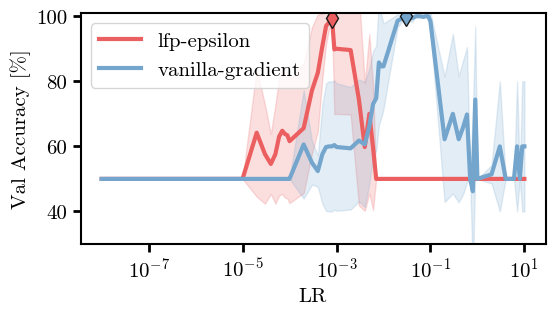

step
MAX: lfp-epsilon - 6e-07
MAX: vanilla-gradient - 1e-08


/tmp/ipykernel_576377/4095843040.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


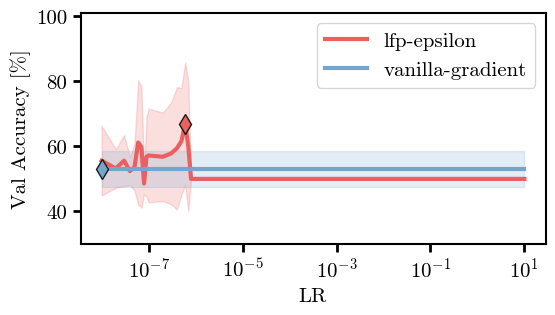

silu
MAX: lfp-epsilon - 0.001
MAX: vanilla-gradient - 0.02


/tmp/ipykernel_576377/4095843040.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


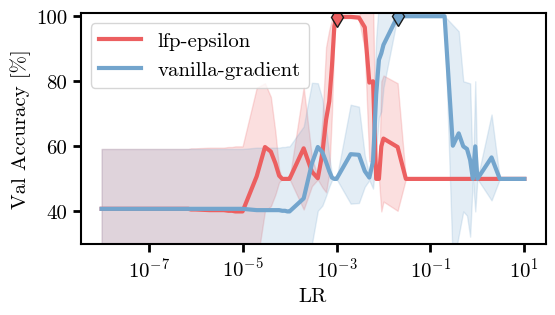

elu
MAX: lfp-epsilon - 0.0004
MAX: vanilla-gradient - 0.006


/tmp/ipykernel_576377/4095843040.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


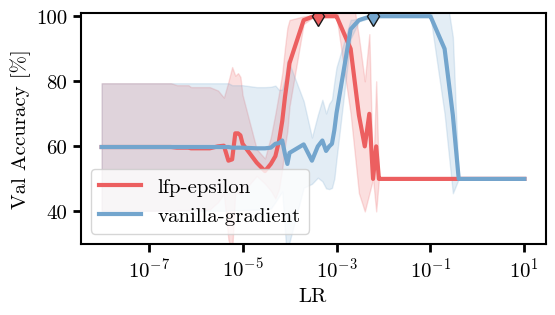

tanh
MAX: lfp-epsilon - 0.0008
MAX: vanilla-gradient - 0.005


/tmp/ipykernel_576377/4095843040.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


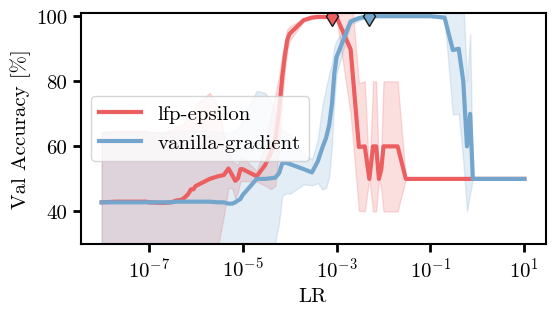

test
leakyrelu
MAX: lfp-epsilon - 0.0008
MAX: vanilla-gradient - 0.04


/tmp/ipykernel_576377/4095843040.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


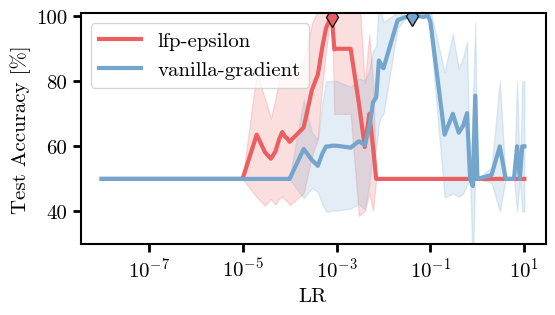

/tmp/ipykernel_576377/4095843040.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


step
MAX: lfp-epsilon - 6e-07
MAX: vanilla-gradient - 1e-08


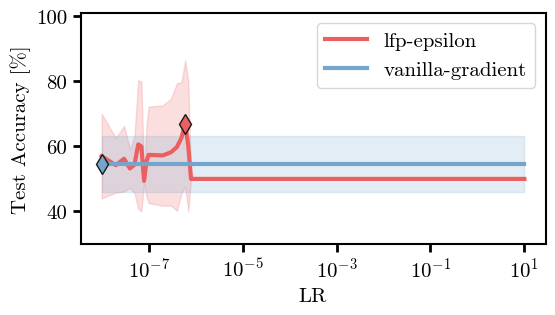

/tmp/ipykernel_576377/4095843040.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


silu
MAX: lfp-epsilon - 0.001
MAX: vanilla-gradient - 0.02


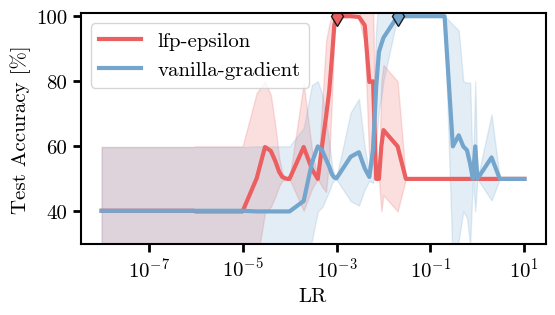

elu
MAX: lfp-epsilon - 0.00030000000000000003
MAX: vanilla-gradient - 0.004


/tmp/ipykernel_576377/4095843040.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


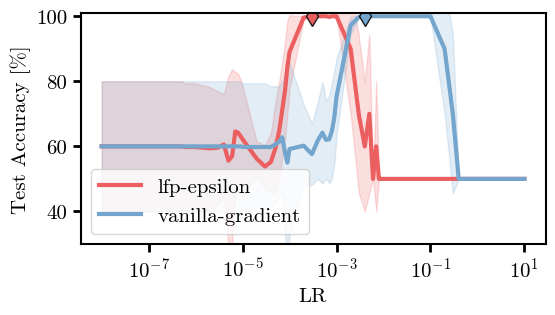

tanh


/tmp/ipykernel_576377/4095843040.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


MAX: lfp-epsilon - 0.0002
MAX: vanilla-gradient - 0.004


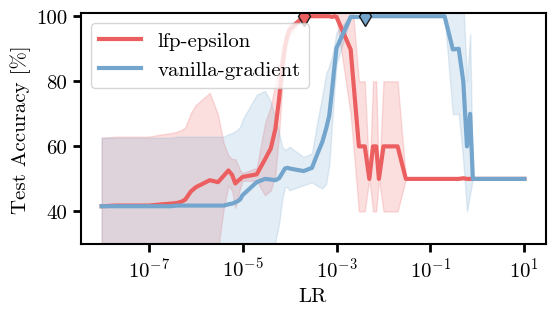

train
leakyrelu
MAX: lfp-epsilon - 0.0008
MAX: vanilla-gradient - 0.05


/tmp/ipykernel_576377/4095843040.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


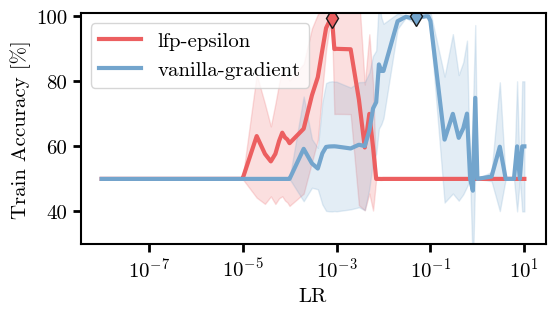

/tmp/ipykernel_576377/4095843040.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


step
MAX: lfp-epsilon - 6e-07
MAX: vanilla-gradient - 1e-08


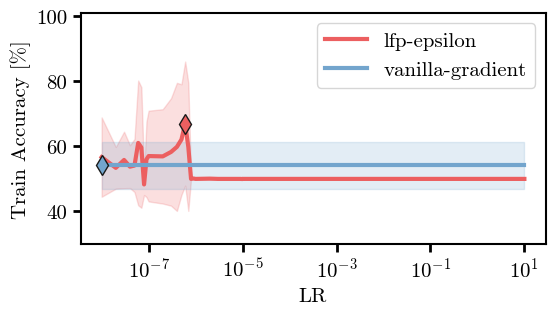

silu
MAX: lfp-epsilon - 0.002
MAX: vanilla-gradient - 0.04


/tmp/ipykernel_576377/4095843040.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


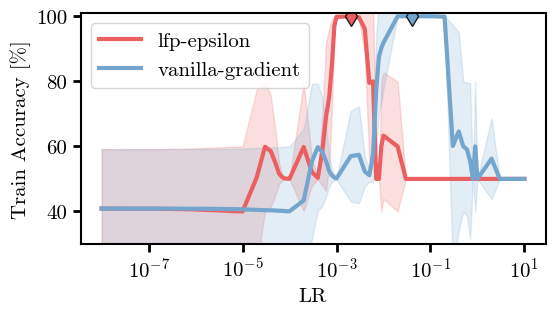

elu
MAX: lfp-epsilon - 0.0004
MAX: vanilla-gradient - 0.02


/tmp/ipykernel_576377/4095843040.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


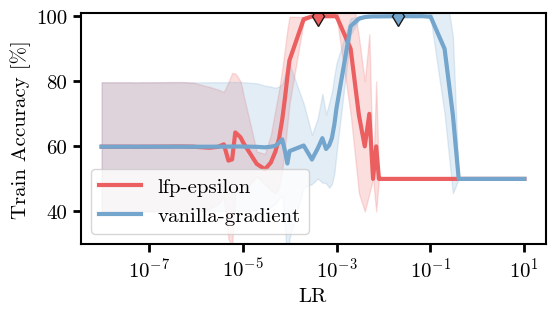

tanh
MAX: lfp-epsilon - 0.0006000000000000001
MAX: vanilla-gradient - 0.03


/tmp/ipykernel_576377/4095843040.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


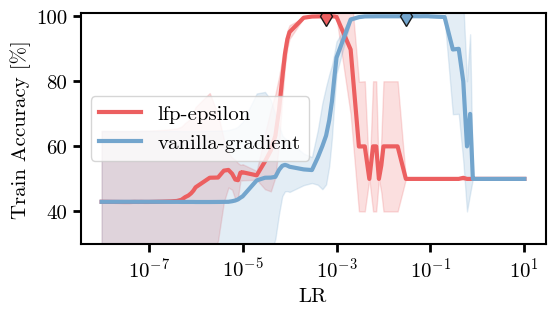

In [9]:
import matplotlib.cm as cm


def plot_accuracies(accuracy_res, name, fname, colormap="Set1"):
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))

    lrs = np.sort([k for k in accuracy_res.keys()])
    methods = [m for m in accuracy_res[lrs[0]].keys()]

    colors = np.linspace(0, 1, 9)
    palette = cm.get_cmap(colormap)(colors)
    pastel = 0.3
    palette = (1 - pastel) * palette + pastel * np.ones((9, 4))

    maxacclrs = []
    maxaccparams = []

    for m, method in enumerate(methods):
        plot_means = []
        plot_stds = []

        parammax = -np.inf
        maxaccparam = ()
        for lr in lrs:

            if np.amax(accuracy_res[lr][method]) > parammax:
                maxaccparam = (
                    method,
                    lr,
                    np.argmax(accuracy_res[lr][method]),
                    np.amax(accuracy_res[lr][method]),
                )
                parammax = np.amax(accuracy_res[lr][method])

            plot_means.append(np.mean(accuracy_res[lr][method]))
            plot_stds.append(np.std(accuracy_res[lr][method]))

        plot_means = np.array(plot_means)
        plot_stds = np.array(plot_stds)

        maxx = lrs[np.argmax(plot_means)]
        maxy = np.max(plot_means)
        print(f"MAX: {method} - {maxx}")
        maxacclrs.append((method, maxx, maxy))
        maxaccparams.append(maxaccparam)

        ax.plot(lrs, plot_means, color=palette[m], label=method, linewidth=3, alpha=1)
        ax.plot(
            maxx,
            maxy,
            color=palette[m],
            marker="d",
            markersize=10,
            markeredgecolor=(0.1, 0.1, 0.1, 1),
        )
        ax.fill_between(
            lrs,
            plot_means + plot_stds,
            plot_means - plot_stds,
            color=palette[m],
            alpha=0.2,
        )

    ax.legend()
    ax.set_xscale("log")

    if name == "test":
        nam = "Test"
    if name == "train":
        nam = "Train"
    if name == "val":
        nam = "Val"

    ax.set_ylabel(f"{nam} Accuracy [%]")
    ax.set_xlabel("LR")
    ax.set_ylim([0.3, 1.01])
    ax.set_yticks([0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels([40, 60, 80, 100])
    ax.tick_params(length=6, width=2)
    # ax.set_xlim([0, 10e-2])
    plt.show()
    fig.savefig(fname)

    return maxacclrs, maxaccparams


maxacclrs = {}
maxaccparams = {}
for name, act_val in accuracies.items():
    print(name)
    maxacclrs[name] = {}
    maxaccparams[name] = {}
    for activation, val in act_val.items():
        print(activation)
        fname = os.path.join(savepath, f"accuracy-{name}-{activation}.svg")
        maxacclrs[name][activation], maxaccparams[name][activation] = plot_accuracies(
            val, name, fname
        )

### Plot Decision Boundaries

leakyrelu
lfp-epsilon 7.000000000000001e-05 1.0
(57460, 2)


/tmp/ipykernel_576377/3718250848.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colormap, 256)
/tmp/ipykernel_576377/3718250848.py:44: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in cnt.collections:


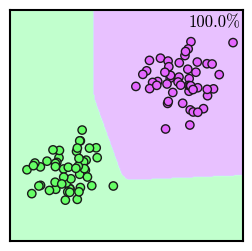

vanilla-gradient 0.0006000000000000001 1.0
(57460, 2)


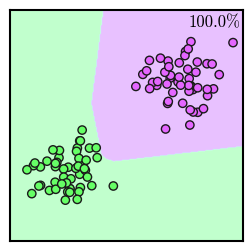

step
lfp-epsilon 6.000000000000001e-08 1.0
(57460, 2)


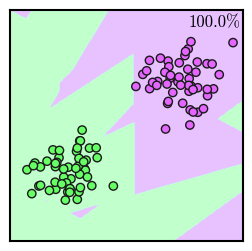

vanilla-gradient 1e-08 0.71999997
(57460, 2)


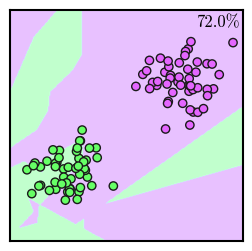

silu
lfp-epsilon 3.0000000000000004e-05 1.0
(57460, 2)


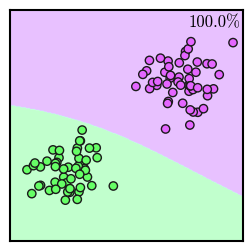

vanilla-gradient 0.0004 1.0
(57460, 2)


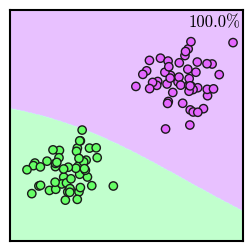

elu
lfp-epsilon 1e-08 1.0
(57460, 2)


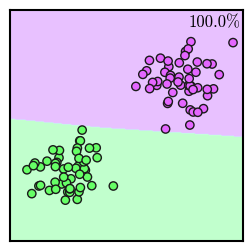

vanilla-gradient 1e-08 1.0
(57460, 2)


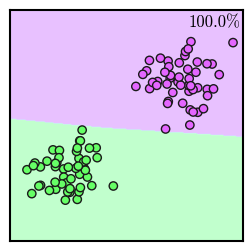

tanh
lfp-epsilon 0.0002 1.0
(57460, 2)


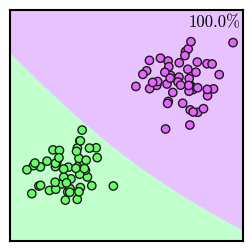

vanilla-gradient 0.002 1.0
(57460, 2)


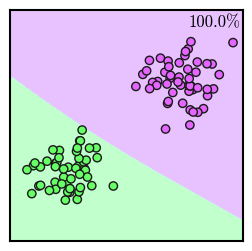

In [10]:
def plot_classifier_boundaries(
    models,
    dataset,
    xlim=(0.4, 2.61),
    ylim=(0.2, 2.8),
    colormap="gist_rainbow",
    fname="",
    acc=0.0,
):
    xgrid = np.arange(xlim[0], xlim[1], 0.01)
    ygrid = np.arange(ylim[0], ylim[1], 0.01)

    xx, yy = np.meshgrid(xgrid, ygrid)
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    grid = np.hstack((r1, r2))

    from matplotlib.colors import ListedColormap

    pastel = 0.4
    cmap = cm.get_cmap(colormap, 256)
    newcolors = [cmap(np.linspace(0.4, 0.92, 128))]
    newcolors = (1 - pastel) * np.repeat(newcolors, 2, axis=1)[0] + pastel * np.ones(
        (256, 4)
    )
    colormap = ListedColormap(newcolors.clip(max=1))

    edgecolor = np.ones(4) * 0.1

    yhats = []
    for model in models:

        yhat = (
            torch.nn.functional.softmax(
                model(torch.from_numpy(grid).float().to(device)), dim=1
            )
            .detach()
            .cpu()
            .numpy()
        )
        # yhats.append(np.argmax(yhat, axis=1)/yhat.shape[1])
        yhats.append(yhat)

    yhat_mean = np.mean(yhats, axis=0)
    print(yhat_mean.shape)
    yhat_mean = np.argmax(yhat, axis=1)
    # yhat_std = np.std(yhats, axis=0)

    zz = yhat_mean.reshape(xx.shape)

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    cnt = ax.contourf(xx, yy, zz, cmap=colormap, alpha=0.4)
    for c in cnt.collections:
        c.set_edgecolor("face")
        c.set_linewidth(0.000000000001)

    samples = copy.deepcopy(dataset.samples)
    np.random.shuffle(samples)
    # samples = samples[:200]

    X = np.array([s[0] for s in samples])
    y = [s[1] for s in samples]
    ax.scatter(
        X[:, 0], X[:, 1], c=y, cmap=colormap, edgecolors=edgecolor, alpha=1, marker="o"
    )
    acc_text = f"{acc*100:.1f}%"
    ax.text(
        0.99,
        0.98,
        acc_text,
        ha="right",
        va="top",
        fontsize=12,
        zorder=50,
        transform=ax.transAxes,
    )

    ax.set_xticks([])
    ax.set_yticks([])
    # plt.axis("off")

    plt.show()

    fig.savefig(fname)


toplot_act = maxaccparams["test"]

if dataset_name == "blobs":
    xlim = (0.4, 2.61)
    ylim = (0.2, 2.8)
elif dataset_name == "circles":
    xlim = (-1.8, 1.61)
    ylim = (-1.61, 1.61)
elif dataset_name == "swirls":
    xlim = (-1.1, 1.1)
    ylim = (-1.1, 1.1)

# Plot decision boundaries for the single best performing model of each method
for activation, toplot in toplot_act.items():
    print(activation)
    for name, lr, idx, acc in toplot:
        print(name, lr, acc)
        plot_classifier_boundaries(
            [trainer.model for trainer in [trainers[activation][lr][name][idx]]],
            test_dataset,
            xlim=xlim,
            ylim=ylim,
            fname=os.path.join(
                savepath, f"boundary-lr-{lr}-name-{name}-activation-{activation}.svg"
            ),
            acc=acc,
        )